In [1]:
# The imports
import pandas as pd
from sqlalchemy import create_engine
# from fuzzywuzzy import fuzz
from rapidfuzz import fuzz


In [2]:
### constant values --------------
thr_similarity = 90

#******************************************************

### The functions ---------------

def is_same(r1, r2):
    # this function takes two records and return true if they are similar
    # similarity: using the NLP (Fuzzy string matching)
    n_col = r1.size - 1  # -1 Bcoz we added a column (checked)
    
    # simple way
    # return (sum(1*(r1==r2))*100/n_col) > thr_similarity
    
    # using fuzzy similarity
    # comparing the columns one by one and add the similarity to s
    s = 0
    for i in range(1, n_col):
        s += fuzz.token_sort_ratio(str(r1[i]), str(r2[i]))
        # s += fuzz.ratio(str(r1[i]), str(r2[i]))
        # s += fuzz.token_sort_ratio(r1[i], r2[i])

    # at the end, the similarity will be averaged and return True if it is high enough
    return (s / (n_col - 1)) > thr_similarity


# *******************************************************

def detect_duplicates(df_patient, df_pcr):
    # this function takes a dataframe as a parameter and returns a new dataframe after removing the duplicates

    # new data frame
    new_df = pd.DataFrame(columns=df_patient.columns)
    df_p = df_patient.copy()

    # adding a column, indicating if this record is checked or not
    df_p['checked'] = False

    # for index, r1 in df_p.iterrows():
    for index in range(0, len(df_p)):
        print(index)
        r1 = df_p.iloc[index]

        # we checked this record
        df_p.at[index, 'checked'] = True

        # create a temporary dataframe containing all similar records with r1
        df_tmp = pd.DataFrame(columns=df_p.columns)
        df_tmp = df_tmp.append(r1)

        # creating a list containing the ID ('patient_id') of all similar records
        l_patient_id = [df_p.iloc[index, 0]]

        # for index2, r2 in df_p.iterrows():
        for index2 in range(index+1, len(df_p)):

            r2 = df_p.iloc[index2]

            # if it was not checked before
            if not df_p.at[index2, 'checked']:
                if is_same(r1, r2):  # if r1 and r2 are similar
                #if (sum(1*(r1==r2))*100/12) > thr_similarity:
                    # we checked this record
                    df_p.at[index2, 'checked'] = True

                    # add the ID to the list
                    l_patient_id.append(df_p.iloc[index2, 0])

                    # add r2 to df_tmp
                    df_tmp = df_tmp.append(r2)

                    # throw out the duplicate from main dataframe
        #                     df_p.drop([index2])

        # find the true pcr value for current record (from pcr data)
        if df_pcr[df_pcr['patient_id'].isin(l_patient_id)].empty:
            # if we did not find the patient pcr
            pcr = 'NaN'
            patient_id = l_patient_id[0]
        elif len(l_patient_id) == 1:
            # if we found the patient pcr but there is only one record id
            pcr = df_pcr[df_pcr['patient_id'].isin(l_patient_id)].iloc[0]['pcr']
            patient_id = l_patient_id[0]
        else:
            pcr = df_pcr[df_pcr['patient_id'].isin(l_patient_id)].mode().iloc[0]['pcr']
            patient_id = df_pcr[(df_pcr['patient_id'].isin(l_patient_id)) & (df_pcr['pcr'] == pcr)].iloc[0, 0]

        # now from all similar record, pick the most common one and replace it with r1 (delete r1 and add the most common one)
        # adding_data = df_tmp.mode().iloc[0]
        adding_data = df_tmp.mode().iloc[0, :]
        adding_data['pcr'] = pcr
        adding_data['patient_id'] = patient_id

        # df_p.drop([index])
        new_df = new_df.append(adding_data)
        # df_p.append(adding_data)

    new_df.drop(columns=['checked'])
    new_df.reset_index(drop=True)
    return new_df

In [3]:
### Main code start from here ---------------

# reading the dataframes
engine = create_engine('sqlite:///data.db' , echo=False)
con = engine.connect()
df_patient = pd.read_sql ( 'select * from patient' , con = con )
df_pcr = pd.read_sql( 'select * from test' , con = con )
con.close()

In [56]:
x = detect_duplicates(df_patient, df_pcr)

0


UnboundLocalError: local variable 'i' referenced before assignment

In [6]:
df_patient

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2
0,221958,matisse,clarke,13.0,rene street,ellenbrook,2527,wa,19710708.0,32.0,08 86018809,westella
1,771155,joshua,elrick,23.0,andrea place,east preston,2074,nsw,19120921.0,34.0,02 97793152,foxdown
2,231932,alice,conboy,35.0,mountain circuit,prospect,2305,nsw,19810905.0,22.0,02 20403934,None
3,465838,sienna,craswell,39.0,cumberlegeicrescent,henty,3620,wa,19840809.0,30.0,02 62832318,jodane
4,359178,joshua,bastiaans,144.0,lowrie street,campbell town,4051,nsw,19340430.0,31.0,03 69359594,None
...,...,...,...,...,...,...,...,...,...,...,...,...
19995,368617,abby,None,19.0,john cleland crescent,boyne island,2290,nsw,19570210.0,NaN,02 92489054,glenmore
19996,796658,dale,priest,19.0,bellchambers crescent,hoppers crossing,3033,wa,19590619.0,31.0,07 20549476,None
19997,511885,alessia,mawlai,4.0,miller street,smithfield,3616,tas,NaN,26.0,03 83466737,None
19998,985932,hannah,mason,1.0,halligan place,beaumaris,2443,wa,19140304.0,25.0,04 41125514,None


In [7]:
df_pcr

,patient_id,pcr
0,653091,N
1,347667,Negative
2,708481,Positive
3,148825,Negative
4,150081,Negative
...,...,...
8795,249457,N
8796,279689,Positive
8797,975612,N
8798,884429,Positive


In [8]:
df_pcr.nunique()

patient_id    8765
pcr              4
dtype: int64

In [9]:
df_pcr.pcr.unique()

array(['N', 'Negative', 'Positive', 'P'], dtype=object)

In [10]:
df_pcr[(df_pcr['pcr']=='Positive')|(df_pcr['pcr']=='P')]

,patient_id,pcr
2,708481,Positive
7,755915,P
11,466326,Positive
15,884141,Positive
16,440459,Positive
...,...,...
8777,116375,Positive
8781,872592,P
8786,541157,P
8796,279689,Positive


In [11]:
# remove data that the pcr are nan
new_df2 = new_df[new_df.pcr != 'NaN']

total_clean_records = len(new_df2)
total_positive = new_df2[(new_df2['pcr']=='Positive')|(new_df2['pcr']=='P')]
p_per = total_positive * 100 / total_clean_records

print('Total number of positive cases: ', total_positive, ' out of ', total_clean_records)
print('percentage of positive cases: ', p_per, '%')



NameError: name 'new_df' is not defined

In [12]:
df_patient.nunique()

patient_id       19798
given_name        1171
surname           4273
street_number      834
address_1         4326
suburb            2925
postcode          2021
state              102
date_of_birth    13654
age                 58
phone_number     17916
address_2         3460
dtype: int64

In [13]:
df_patient['age'].value_counts().nlargest(10)

29.0    1036
31.0    1031
30.0    1017
28.0    1016
32.0     959
27.0     952
33.0     900
26.0     840
25.0     725
34.0     696
Name: age, dtype: int64

In [14]:
df_patient['state'].value_counts().nlargest(10)

nsw    6143
vic    4352
qld    3516
wa     1580
sa     1391
tas     507
act     250
nt      132
nss       7
ns        6
Name: state, dtype: int64

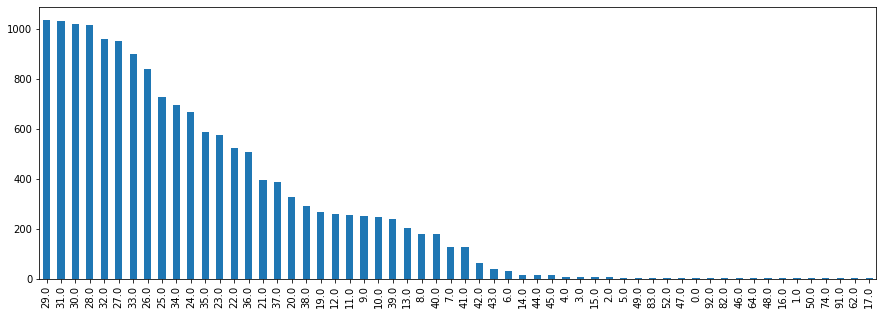

In [15]:
df_patient['age'].value_counts().plot(kind='bar', figsize=(15,5))

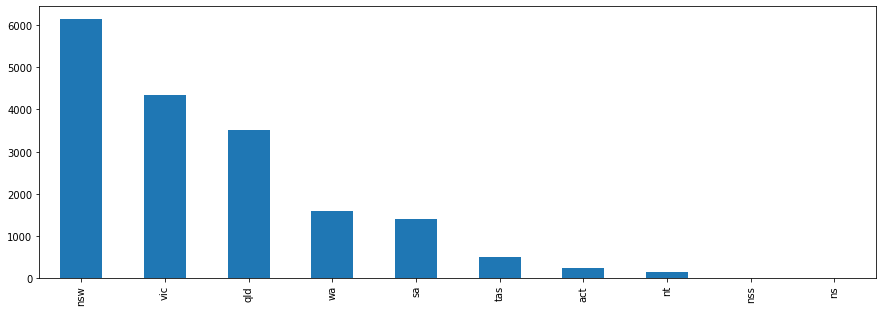

In [16]:
df_patient['state'].value_counts().nlargest(10).plot(kind='bar', figsize=(15,5))

In [17]:
df_patient['age'].value_counts()

29.0    1036
31.0    1031
30.0    1017
28.0    1016
32.0     959
27.0     952
33.0     900
26.0     840
25.0     725
34.0     696
24.0     666
35.0     587
23.0     576
22.0     524
36.0     508
21.0     393
37.0     387
20.0     328
38.0     289
19.0     266
12.0     259
11.0     255
9.0      252
10.0     248
39.0     239
13.0     202
8.0      180
40.0     179
7.0      128
41.0     127
42.0      64
43.0      39
6.0       31
14.0      16
44.0      16
45.0      15
4.0        7
3.0        6
15.0       6
2.0        5
5.0        4
49.0       3
83.0       3
52.0       3
47.0       3
0.0        2
92.0       2
82.0       2
46.0       2
64.0       1
48.0       1
16.0       1
1.0        1
50.0       1
74.0       1
91.0       1
62.0       1
17.0       1
Name: age, dtype: int64

In [18]:
df_patient['state'].value_counts()

nsw     6143
vic     4352
qld     3516
wa      1580
sa      1391
        ... 
nsjw       1
ng         1
vif        1
qlg        1
vie        1
Name: state, Length: 102, dtype: int64

In [19]:
from rapidfuzz import process, utils
# process.extract

In [20]:
r1 = df_patient.iloc[0]
r2 = df_patient.iloc[0]
r1.size

12

In [21]:
n_col = r1.size
s = 0
for i in range(1, n_col):
    
    s += fuzz.token_sort_ratio(str(r1[i]), str(r2[i]))
    # s += fuzz.ratio(str(r1[i]), str(r2[i]))
    # s += fuzz.token_sort_ratio(r1[i], r2[i])

# at the end, the similarity will be averaged and return True if it is high enough
print ((s / (n_col - 1)) > thr_similarity)

True


In [25]:
xx = df_patient.astype(str).values.tolist()
list_df_pcr = df_pcr.astype(str).values.tolist()

new_df = pd.DataFrame(columns=df_patient.columns)
for index in range(0, len(xx)):
    print(index)
    r1 = xx[index]

    # we checked this record
#     df_p.at[index, 'checked'] = True

    # create a temporary dataframe containing all similar records with r1
#     df_tmp = pd.DataFrame(columns=df_p.columns)
#     df_tmp = df_tmp.append(r1)
    df_tmp = [r1]

    # creating a list containing the ID ('patient_id') of all similar records
    l_patient_id = [xx[index][0]]

    # for index2, r2 in df_p.iterrows():
    for index2 in range(index+1, len(xx)):

        r2 = xx[index2]

        # if it was not checked before
        #if not df_p.at[index2, 'checked']:
        #if is_same(r1, r2):  # if r1 and r2 are similar
        if fuzz.token_sort_ratio(str(xx[index][1:]), str(xx[index2][1:])) > thr_similarity:
            # we checked this record
            #df_p.at[index2, 'checked'] = True

            # add the ID to the list
            l_patient_id.append(xx[index2][0])

            # add r2 to df_tmp
            df_tmp.append(r2)

                # throw out the duplicate from main dataframe
    #                     df_p.drop([index2])

    # find the true pcr value for current record (from pcr data)
    if df_pcr[df_pcr['patient_id'].isin(l_patient_id)].empty:
        # if we did not find the patient pcr
        pcr = 'NaN'
        patient_id = l_patient_id[0]
    elif len(l_patient_id) == 1:
        # if we found the patient pcr but there is only one record id
        pcr = df_pcr[df_pcr['patient_id'].isin(l_patient_id)].iloc[0]['pcr']
        patient_id = l_patient_id[0]
    else:
        pcr = df_pcr[df_pcr['patient_id'].isin(l_patient_id)].mode().iloc[0]['pcr']
        patient_id = df_pcr[(df_pcr['patient_id'].isin(l_patient_id)) & (df_pcr['pcr'] == pcr)].iloc[0, 0]

    # now from all similar record, pick the most common one and replace it with r1 (delete r1 and add the most common one)
    # adding_data = df_tmp.mode().iloc[0]
    adding_data = pd.DataFrame (df_tmp,columns=df_patient.columns)
    adding_data = adding_data.mode().iloc[0, :]
    adding_data['pcr'] = pcr
    adding_data['patient_id'] = patient_id

    # df_p.drop([index])
    new_df = new_df.append(adding_data)
    # df_p.append(adding_data)

# new_df.drop(columns=['checked'])
new_df.reset_index(drop=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


TypeError: list indices must be integers or slices, not tuple

In [23]:
df_patient.columns

Index(['patient_id', 'given_name', 'surname', 'street_number', 'address_1',
       'suburb', 'postcode', 'state', 'date_of_birth', 'age', 'phone_number',
       'address_2'],
      dtype='object')

In [28]:
df_patient[(df_patient['surname']=='stephenson')&(df_patient['given_name']=='mitchell')]

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2
539,200235,mitchell,stephenson,56.0,rosman circuit,eastwood,2539,sa,19328814.0,39.0,03 85151806,None
2465,246649,mitchell,stephenson,58.0,rosman circuit,eastwood,2539,sa,19320814.0,39.0,03 85151806,None
18111,258116,mitchell,stephenson,10.0,cumpston place,bonville,6415,qld,19590128.0,29.0,03 45750142,terranora


In [46]:
dict_df_pcr = df_pcr.set_index('patient_id')['pcr'].to_dict()

In [48]:
dict_df_pcr[653091]

'N'

In [49]:
dict_df_pcr[1234]

KeyError: 1234

In [51]:
653091 in dict_df_pcr

True

In [54]:
x_key = dict_df_pcr.get(12134)
print(x_key)

None
